<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


In [ ]:
!wget https://i0.wp.com/tvtambov.ru/wp-content/uploads/2023/11/snprud-mchs.jpg?resize=780%2C445&ssl=1

--2024-02-26 20:18:37--  https://i0.wp.com/tvtambov.ru/wp-content/uploads/2023/11/snprud-mchs.jpg?resize=780%2C445
Resolving i0.wp.com (i0.wp.com)... 192.0.77.2
Connecting to i0.wp.com (i0.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104511 (102K) [image/jpeg]
Saving to: ‘snprud-mchs.jpg?resize=780,445’

snprud-mchs.jpg?res 100%[===================>] 102.06K  --.-KB/s    in 0.01s   

2024-02-26 20:18:37 (9.40 MB/s) - ‘snprud-mchs.jpg?resize=780,445’ saved [104511/104511]



# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from torch.autograd import Variable
import torchvision.utils
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary


from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import kurtosis, skew
from scipy import stats
import statistics


import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
from tqdm.notebook import tqdm, trange
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path

import skimage.io
from skimage.transform import resize

%matplotlib inline

<ipython-input-2-0a7aff7b0e3d>:20: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
# <тут Ваш код>

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, train_size=0.75, shuffle=False)
train_loader = torch.utils.data.DataLoader(torch.FloatTensor(train_photos), batch_size=32, drop_last=True)
val_loader = torch.utils.data.DataLoader(torch.FloatTensor(val_photos), batch_size=32, drop_last=True)

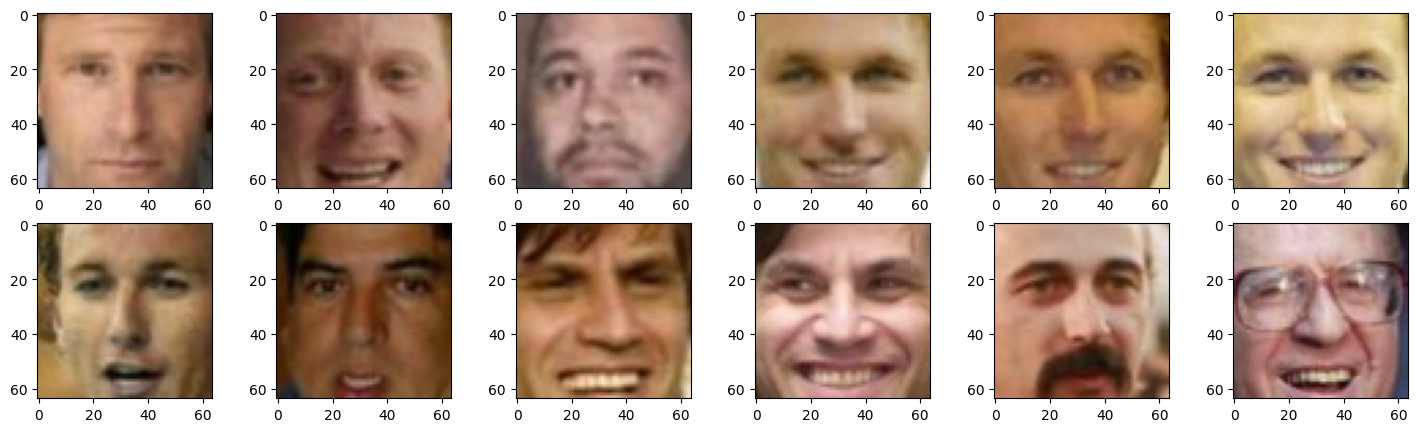

In [ ]:
# посмотрим на первые 12 картинок в трейне
plt.figure(figsize=(18, 5))

for i in range(6):
  plt.subplot(2, 6, i+1)
  plt.imshow(train_loader.dataset[i])

  plt.subplot(2, 6, i+7)
  plt.imshow(train_loader.dataset[i+6])

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 128 # <your code here> # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
pict = train_loader.dataset[0]
in_features = pict.shape[0] * pict.shape[1] * pict.shape[2]

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
      super(Autoencoder, self).__init__()
      #<определите архитектуры encoder и decoder>
      # Обратите внимание на формат, в котором функция fetch() возвращает data
      # encoder
      self.encoder = nn.Sequential(
          nn.Linear(in_features=in_features, out_features=512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=dim_code)

      )
      # decoder
      self.decoder = nn.Sequential(
          nn.Linear(in_features=dim_code, out_features=512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=in_features)
      )

    def forward(self, x):
      latent_code = self.encoder(x)
      reconstruction = torch.sigmoid(self.decoder(latent_code))#.view(-1, 64, 64, 3)
      return reconstruction#, latent_code

        # <реализуйте forward проход автоэнкодера
        # в качестве возвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated

In [ ]:
def mem_cuda(device=0):
    n = 1024 * 1024
    t = torch.cuda.get_device_properties(device).total_memory // n
    r = torch.cuda.memory_reserved(device) // n
    a = torch.cuda.memory_allocated(device) // n
    d = torch.cuda.get_device_name(device)
    f1 = t - (r + a)
    f2 = (r - a) # free inside reserved
    info = f'Device:{d}, all memory:{t}MB,  memory_reserved:{r}MB,  memory_allocated:{a}MB, free inside reserved:{f2}MB, free:{f1}MB'
    return info

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
mem_cuda()

'Device:Tesla T4, all memory:15102MB,  memory_reserved:0MB,  memory_allocated:0MB, free inside reserved:0MB, free:15102MB'

In [ ]:
criterion = nn.MSELoss() # <loss>

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters()) # <Ваш любимый оптимизатор>

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

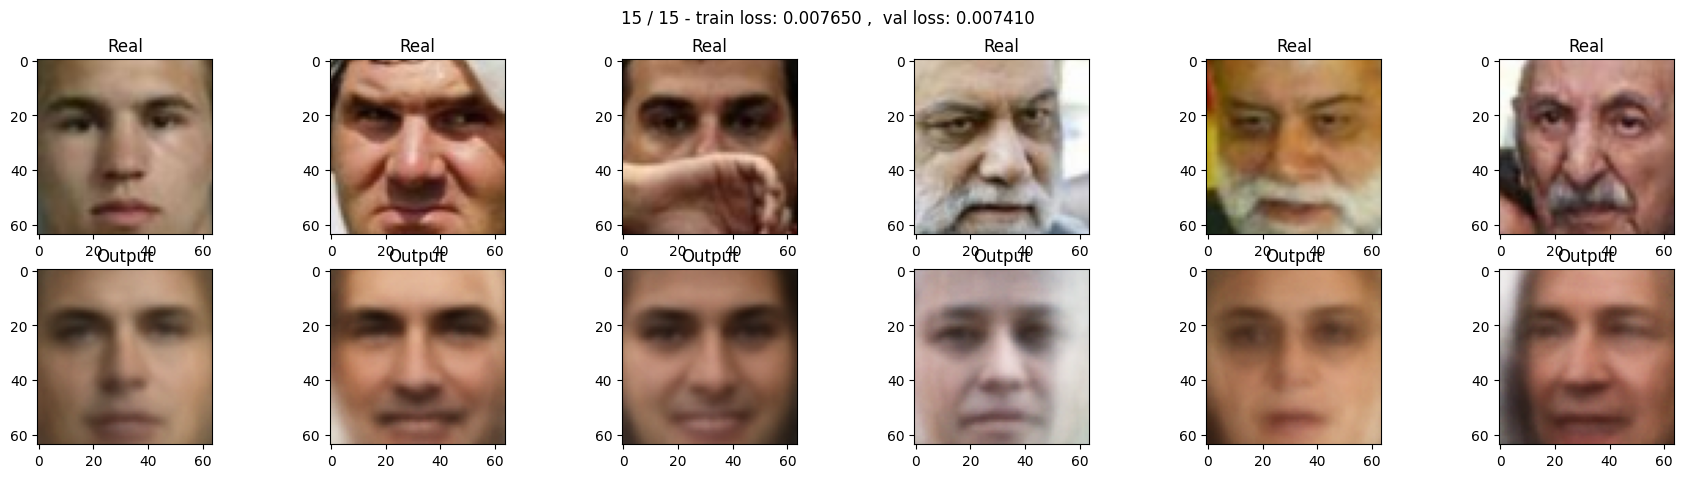

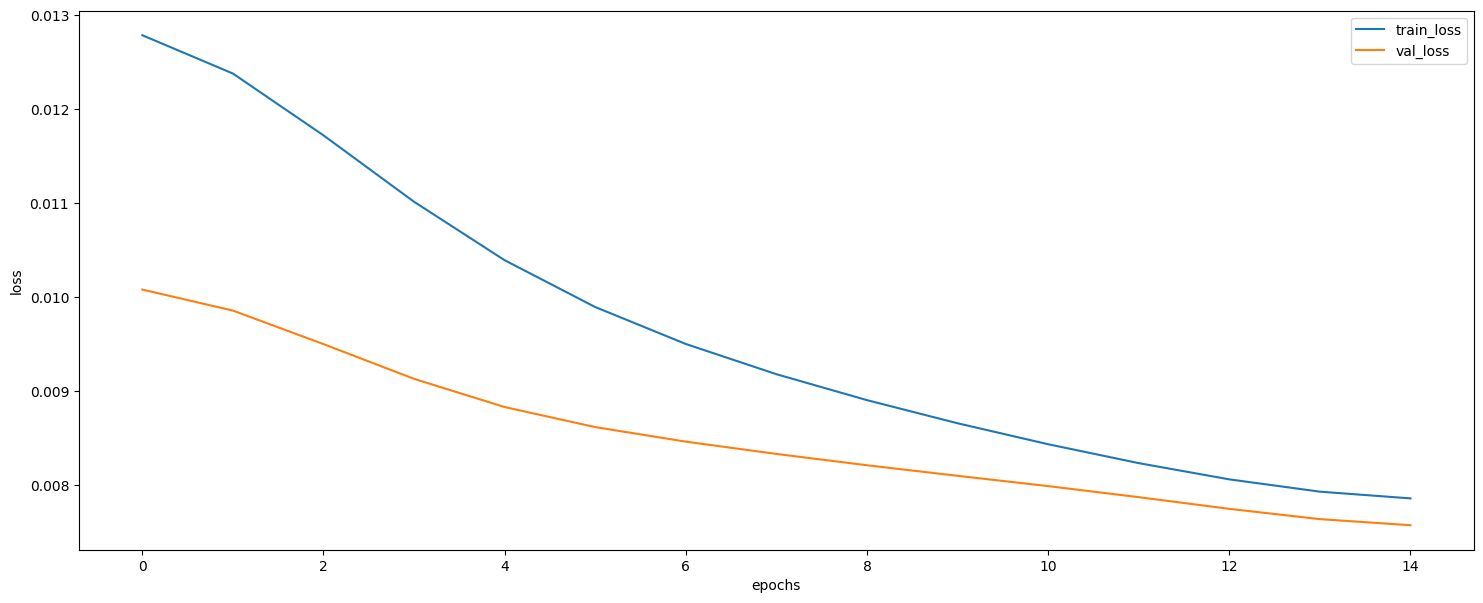

Device:Tesla T4, all memory:15102MB,  memory_reserved:294MB,  memory_allocated:223MB, free inside reserved:71MB, free:14585MB


In [ ]:
# <тут Ваш код тренировки автоэнкодера>
n_epochs = 15

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = X_batch.view(-1, in_features).to(device).float()
        reconstruction = autoencoder(inputs)
        loss = criterion(reconstruction, inputs)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
          inputs = X_batch.view(-1, in_features).to(device).float()
          reconstruction = autoencoder(inputs)
          loss = criterion(reconstruction, inputs)
          val_losses_per_epoch.append(loss.item())
    val_losses.append(np.mean(val_losses_per_epoch))

    # посмотрим как востанавливаются лица на валидации по эпохам
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    val = reconstruction.detach().cpu()
    ground_truth = X_batch.numpy()

    clear_output(wait=True)
    plt.figure(figsize=(22, 5))

    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.title('Real')
        plt.imshow(ground_truth[i])

        plt.subplot(2, 6, i+7)
        plt.title('Output')
        plt.imshow(val[i])

    plt.suptitle('%d / %d - train loss: %f ,  val loss: %f' % (epoch+1, n_epochs, train_losses[epoch], val_losses[epoch]))
    plt.show()

    plt.figure(figsize=(18, 7))
    plt.plot(gaussian_filter1d(train_losses, sigma=2), label="train_loss")
    plt.plot(gaussian_filter1d(val_losses, sigma=2), label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    print(mem_cuda())

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
  for batch in val_loader:
    inputs = batch.view(-1, in_features).to(device).float()
    reconstruction = autoencoder(inputs)
    reconstruction = reconstruction.view(-1, 64, 64, 3)
    result = reconstruction.cpu().detach().numpy()
    ground_truth = batch.numpy()
    break

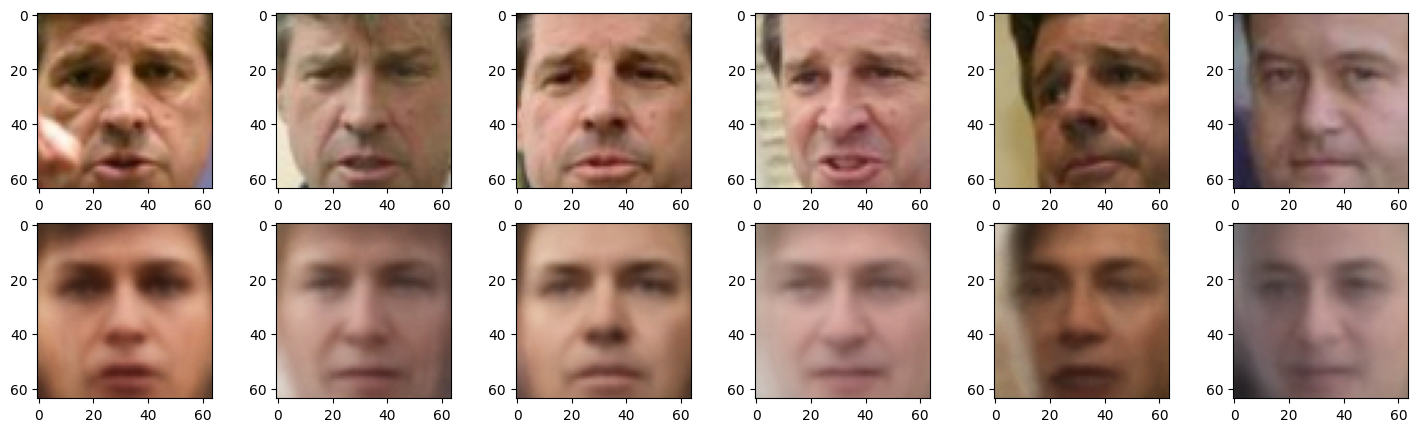

In [ ]:
plt.figure(figsize=(18, 5))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(ground_truth[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(result[i])

plt.show();

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

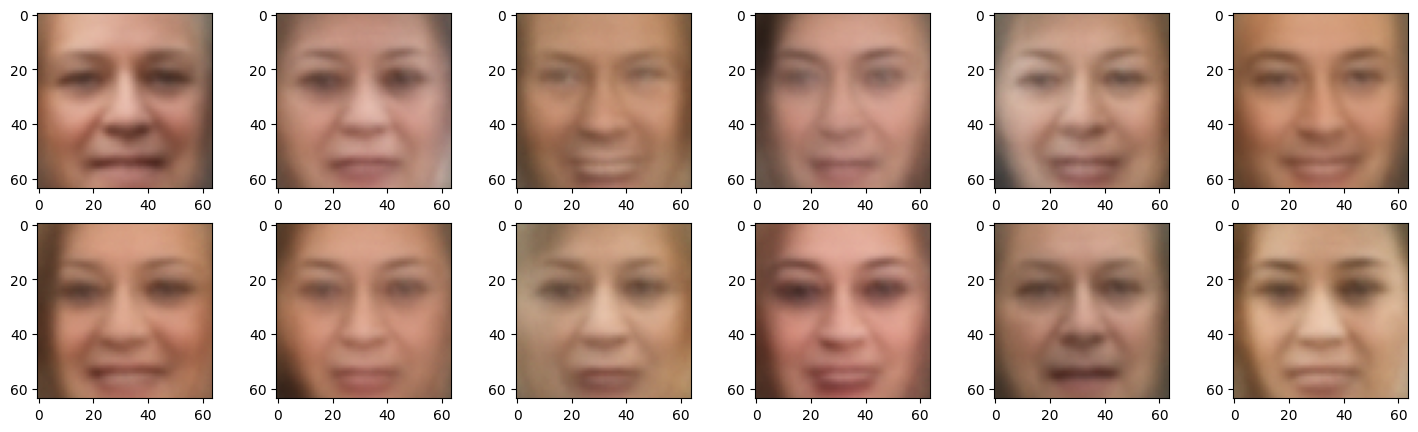

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
# z = np.random.randn(25, <latent_space_dim>)
# output = <скормите z декодеру>
# <выведите тут полученные картинки>

z = np.random.randn(25, dim_code) * 3
output = autoencoder.sample(torch.FloatTensor(z).to(device))
result = output.cpu().detach().numpy()

plt.figure(figsize=(18, 5))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(result[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(result[i + 6])

plt.show()

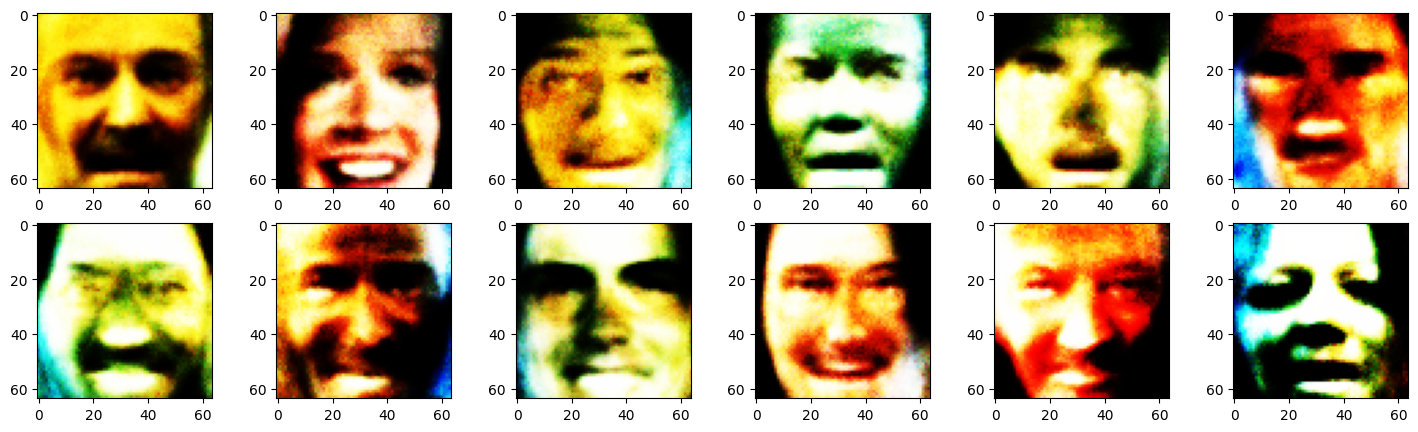

In [ ]:
z = np.random.randn(25, dim_code) * 78
output = autoencoder.sample(torch.FloatTensor(z).to(device))
result = output.cpu().detach().numpy()

plt.figure(figsize=(18, 5))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(result[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(result[i + 6])

plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

Smiling 96 Frowning 20


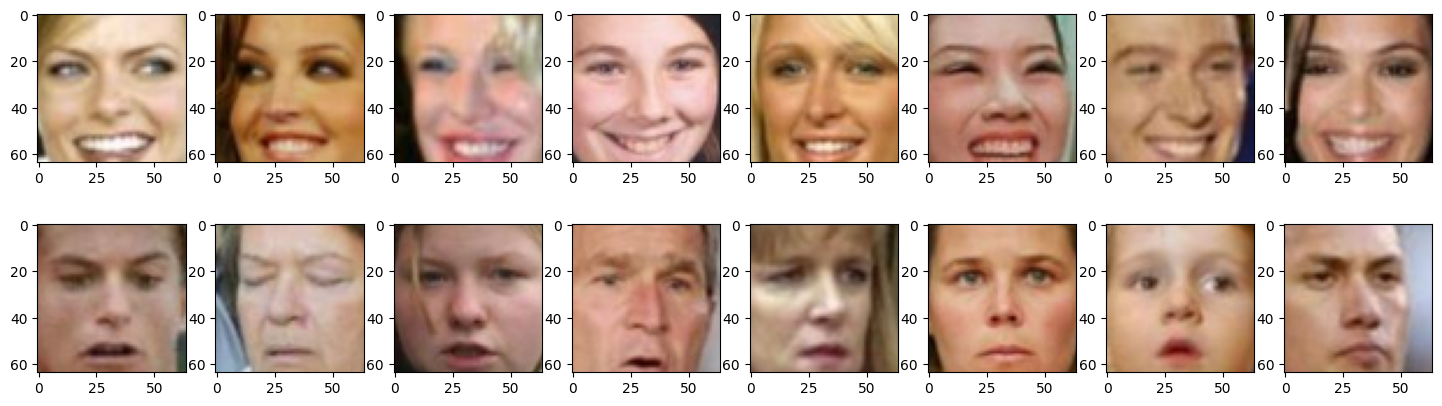

In [ ]:
# <ваш код здесь>
# несколько (~15) людей с улыбками и столько же без

n = 16
indx_sm = attrs[(attrs['Smiling'] > 2) & (attrs['No Eyewear'] > 2) & (attrs['Mustache'] < 0)].index
indx_fr = attrs[(attrs['Frowning'] > 2) & (attrs['No Eyewear'] > 2) & (attrs['Mustache'] < 0)].index
print('Smiling', len(indx_sm), 'Frowning', len(indx_fr))

indx_sm = np.random.choice(indx_sm, n, replace=False)
indx_fr = np.random.choice(indx_fr, n, replace=False)
result1 = data[indx_sm]
result2 = data[indx_fr]

plt.figure(figsize=(18, 5))

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(result1[i])

    plt.subplot(2, 8, i+9)
    plt.imshow(result2[i])

plt.show();

del result1

In [ ]:
# Вычислим латентный вектор для всех улыбающихся людей
inputs = torch.FloatTensor(data[indx_sm])
inputs = inputs.view(-1, in_features).to(device).float()
output = autoencoder.encoder(inputs)
result_smile = np.mean(output.cpu().detach().numpy(), 0)

# Вычислим латентный вектор для всех грустных людей
inputs = torch.FloatTensor(data[indx_fr])
inputs = inputs.view(-1, in_features).to(device).float()
output = autoencoder.encoder(inputs)
result_frowning = np.mean(output.cpu().detach().numpy(), 0)

# Вычислим, собственно, вектор улыбки -- посчитав разность между средним латентным вектором
# улыбающихся людей и средним латентным вектором грустных людей

smile = result_smile - result_frowning

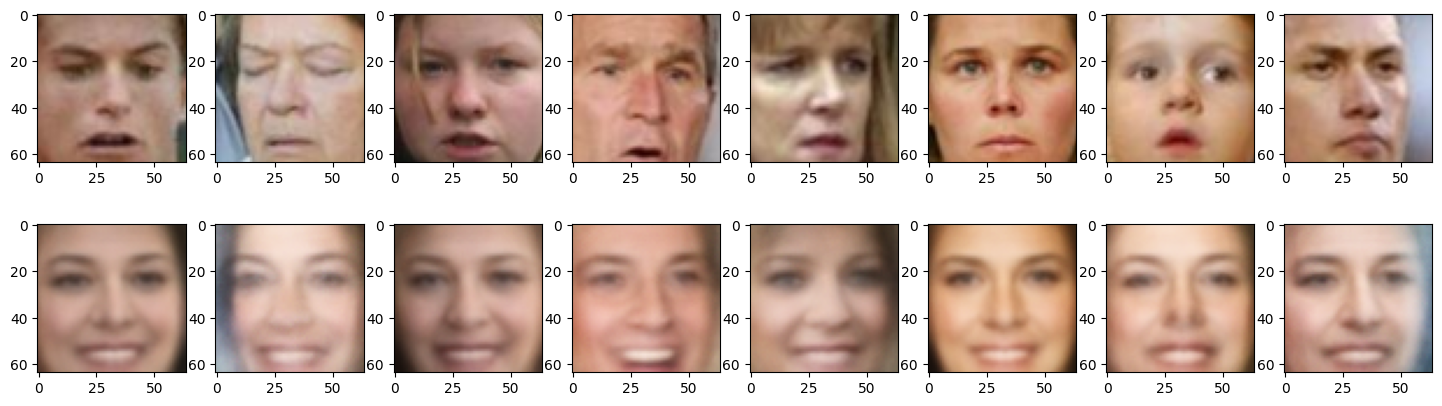

In [ ]:
# Приделаем улыбку грустному человеку: добавим 'smile'
# к латентному вектору грустного человека и прогоним полученный вектор через decoder

inputs = torch.FloatTensor(data[indx_fr])
inputs = inputs.view(-1, in_features).to(device).float()
output = autoencoder.encoder(inputs) + torch.tensor(smile).to(device)
output = autoencoder.sample(output)
result = output.cpu().detach().numpy()

plt.figure(figsize=(18, 5))

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(result2[i])

    plt.subplot(2, 8, i+9)
    plt.imshow(result[i])
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
features = 8
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 214969319.22it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 89465061.91it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72415436.13it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13472792.62it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
flat_size = features * 28 * 28

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        super(VAE, self).__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, features, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(features),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, features * 2)
            )

        self.decoder = nn.Sequential(
            nn.Linear(features, 512),
            nn.ReLU(),
            nn.Linear(512, flat_size),
            nn.ReLU(),
            nn.Unflatten(1, (features, 28, 28)),
            nn.ConvTranspose2d(features, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=1, padding=2)
            )

    def encode(self, xx):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>

        x = self.encoder(xx).view(xx.shape[0], 2, -1)
        mu = x[:, 0, :]
        logsigma = x[:, 1, :]
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>

            std = torch.exp(0.5 * logsigma)  # стандартное отклонение
            eps = torch.randn_like(std)  # `randn_like` так как нам нужен такого же размера
            sample = mu + (eps * std)  # сэмплирование как будто оно происходит из входного пространства
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>

        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>

        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        return reconstruction, mu, logsigma

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu ** 2 - logsigma.exp()) # <напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum') # <binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction) # <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters()) #<Ваш любимый оптимизатор>

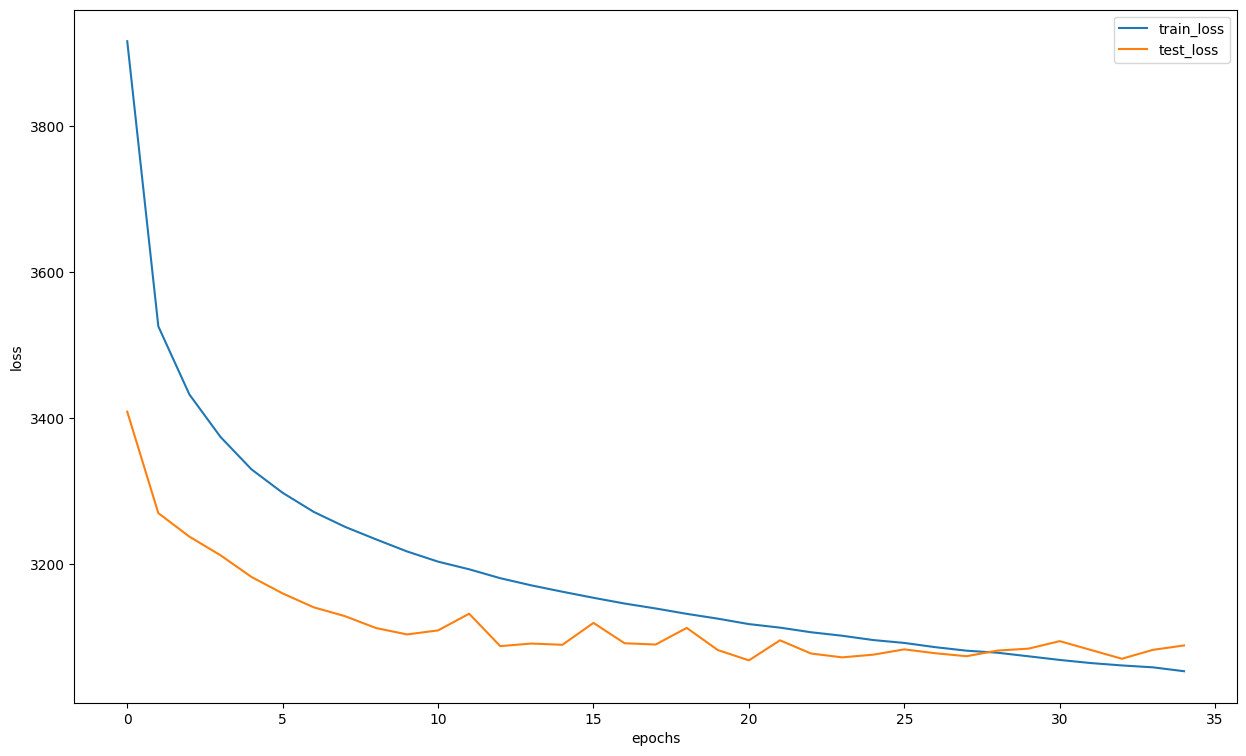

In [ ]:
# <обучите модель на датасете MNIST>

n_epochs = 35
train_losses = []
test_losses = []
mus = torch.Tensor()
labels = torch.Tensor()

for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, label in train_loader:
        optimizer.zero_grad()
        reconstruction, mu, logsigma = autoencoder(batch.to(device))
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    test_losses_per_epoch = []
    with torch.no_grad():
        for batch, label in test_loader:
          reconstruction, mu, logsigma = autoencoder(batch.to(device))
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
          test_losses_per_epoch.append(loss.item())
          if epoch == n_epochs - 1:
            mus = torch.cat((mus, mu.to('cpu')), 0)
            labels = torch.cat((labels, label), dim=0)

    test_losses.append(np.mean(test_losses_per_epoch))

    # Visualize tools
    clear_output(wait=True)

    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(test_losses, label="test_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

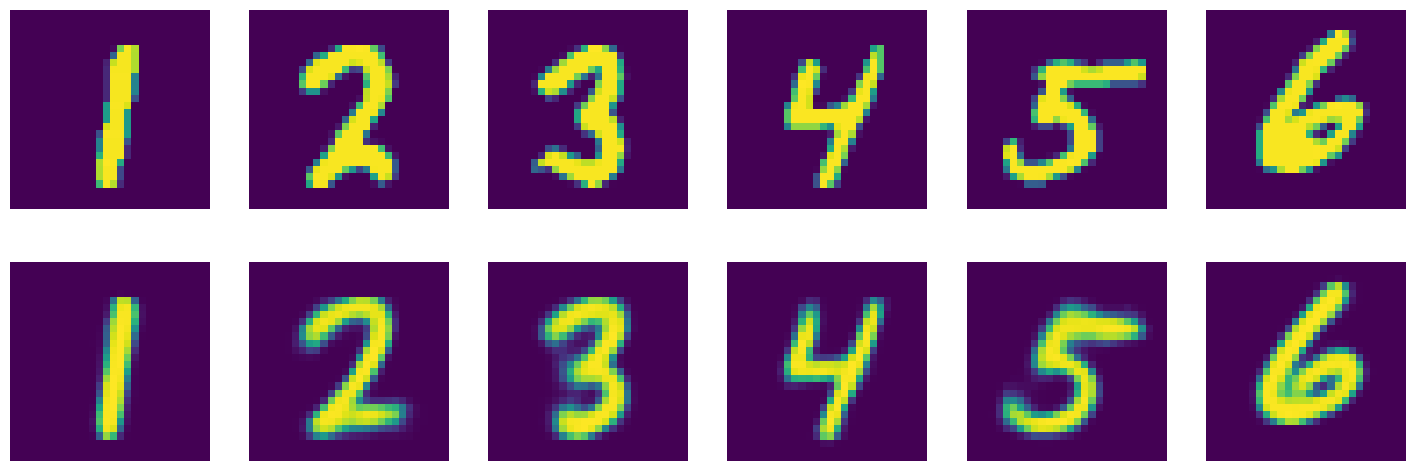

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(2, 6, i + 1)
  plt.axis("off")
  plt.imshow(batch[i][0].cpu().detach().numpy())
  plt.subplot(2, 6, i + 7)
  plt.axis("off")
  plt.imshow(reconstruction[i][0].cpu().detach().numpy())
plt.show();

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

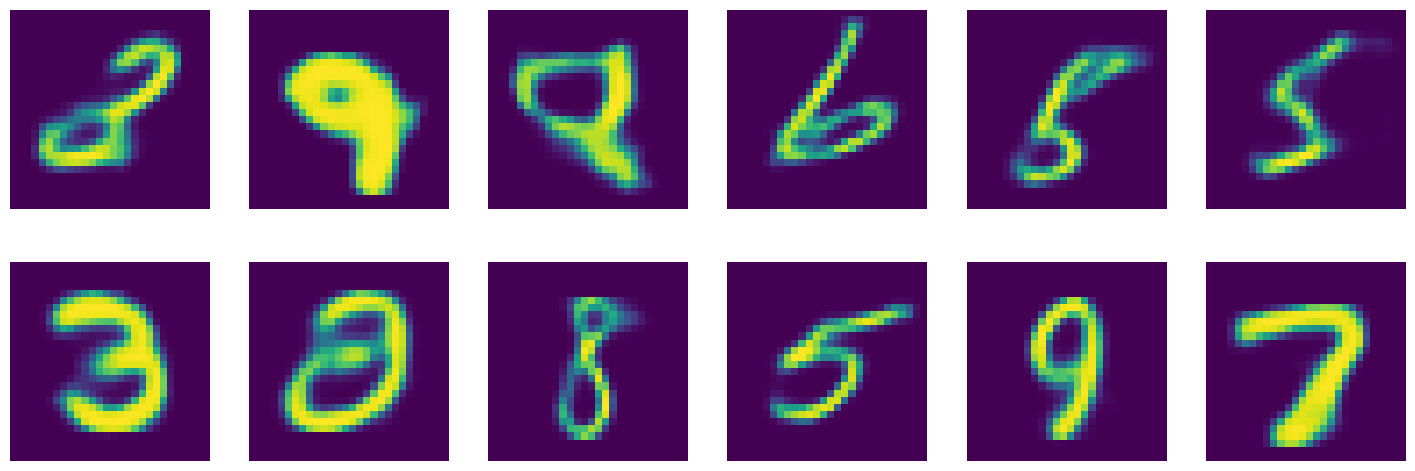

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, features) for i in range(12)])
output = autoencoder.decode(torch.FloatTensor(z).to(device)) #<скормите z декодеру>

#<выведите тут полученные картинки>
plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(2, 6, i + 1)
  plt.axis("off")
  plt.imshow(output[i][0].cpu().detach().numpy())
  plt.subplot(2, 6, i + 7)
  plt.axis("off")
  plt.imshow(output[i + 6][0].cpu().detach().numpy())
plt.show();

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

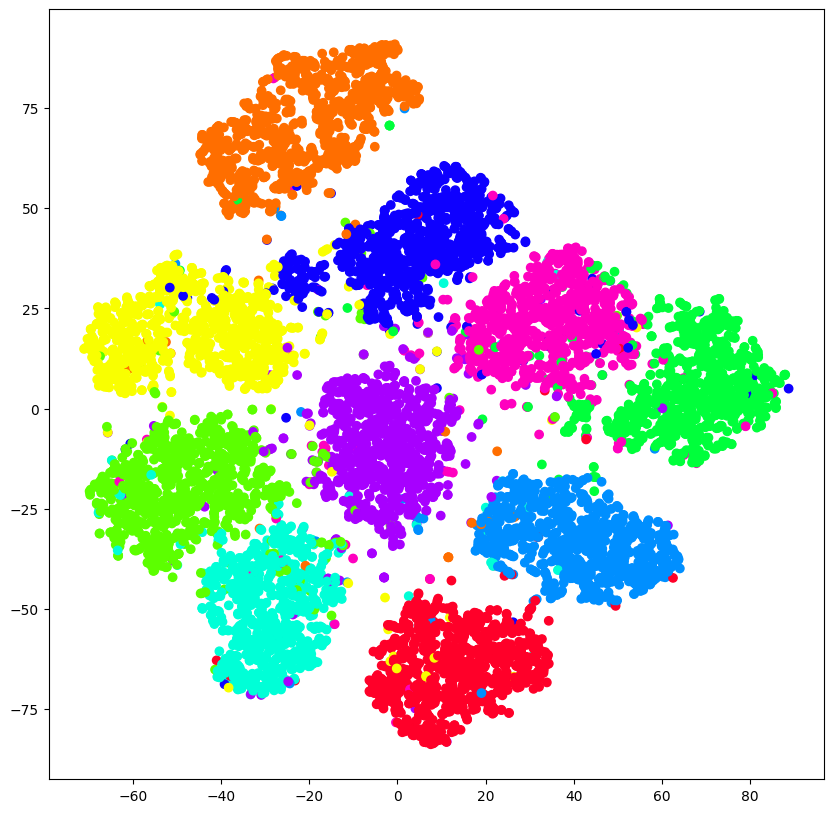

In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
mus_embedded = torch.from_numpy(TSNE(n_components=2).fit_transform(mus))
labels = labels.view(-1, 1)
mus_emb = torch.cat((mus_embedded, labels), dim = 1)

plt.figure(figsize=(10, 10))
plt.scatter(mus_emb[:, 0], mus_emb[:, 1], c=mus_emb[:, 2], cmap='gist_rainbow')

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
# фиксация SEED
SEED = 42
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# Подключение Google-диска для сохранения весов
from google.colab import drive
drive.mount('/content/drive/')
BASE_DIR = Path('/content/drive/MyDrive/autoencoders/')

Mounted at /content/drive/


In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# наиболее часто используемые параметры обучения
epochs = 30 # количество эпох обучения
lr = 3e-4 # базовое значение Learning Rate
init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
image_channels = 1 # количество каналов изображения
cvae_latent_dim = 4 # размерность латентного вектора (скрытого пространства)
kernel_size = 3 # базовый размер сверточного ядра
batchNorm_momentum = 0.1 # параметры нормализации
num_classes = 10 # количество классов
img_size = 28 # размер изображения

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())

        self.mu = nn.Linear(init_channels*16, cvae_latent_dim)

        self.logsigma = nn.Linear(init_channels*16, cvae_latent_dim)

        self.embed_class = nn.Linear(num_classes, img_size * img_size)

        # в in_channels добавлен дополнительный фильтр для меток (label)
        self.embed_data = nn.ConvTranspose2d(in_channels=image_channels + 1, out_channels=image_channels, kernel_size=1, padding=0, output_padding=0)

        self.decoder_input = nn.Linear(cvae_latent_dim + num_classes, init_channels*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, embedded_class], dim=1)
        x = self.embed_data(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction


    def forward(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        return z

In [ ]:
adcriterion = loss_vae
cvaeautoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(cvaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:
def train_cvae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []

    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        # Train mode
        model.train()

        train_losses_per_epoch = []
        for _, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = X_batch
            images = images.to(device)
            labels = labels.to(device)
            reconstructed, mu, logsigma = model(images, labels)
            loss = criterion(images, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)

        if is_scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                images_val, labels_val = X_batch_val
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)
                reconstructed_val, mu_val, logsigma_val = model(images_val, labels_val)
                loss_val = criterion(images_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())

        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))

        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualisations
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle(f"{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 6)}, val_loss:{round(val_loss_mean, 6)}", fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(images_val[k].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Real / ' + str(k+1))
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(reconstructed_val[k-5].detach().cpu().squeeze(0), cmap='gray')
              axis[k].set_title('Reconstruction')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left = 0, right = len(train_losses))
              axis[k].set_ylim(bottom = 3400, top = max(max(train_losses), max(val_losses))*1.05)

        #plt.tight_layout()
        plt.show()

        # Delete cache
        images.to('cpu')
        del images
        images_val.to('cpu')
        del images_val
        torch.cuda.empty_cache()

        # load best model weights
        model.load_state_dict(best_model_weights)

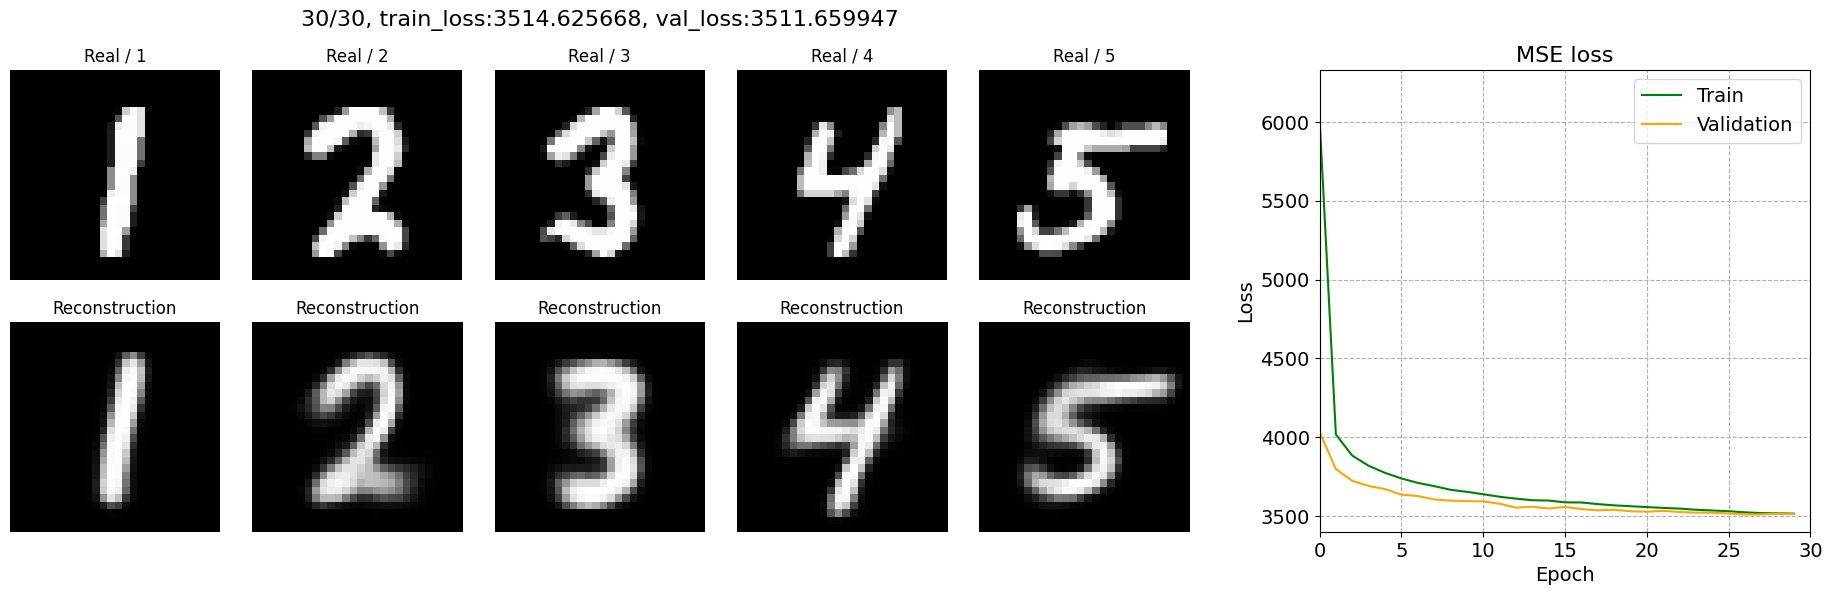

In [ ]:
train_cvae(model=cvaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

In [ ]:
# Сохраняем веса модели
torch.save(cvaeautoencoder.state_dict(), Path(str(BASE_DIR) + str('/cvae')))

In [ ]:
# Загрузка весов
сvaeautoencoder = CVAE().to(device)
сvaeautoencoder.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/cvae')), map_location=torch.device('cuda')))
сvaeautoencoder.eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

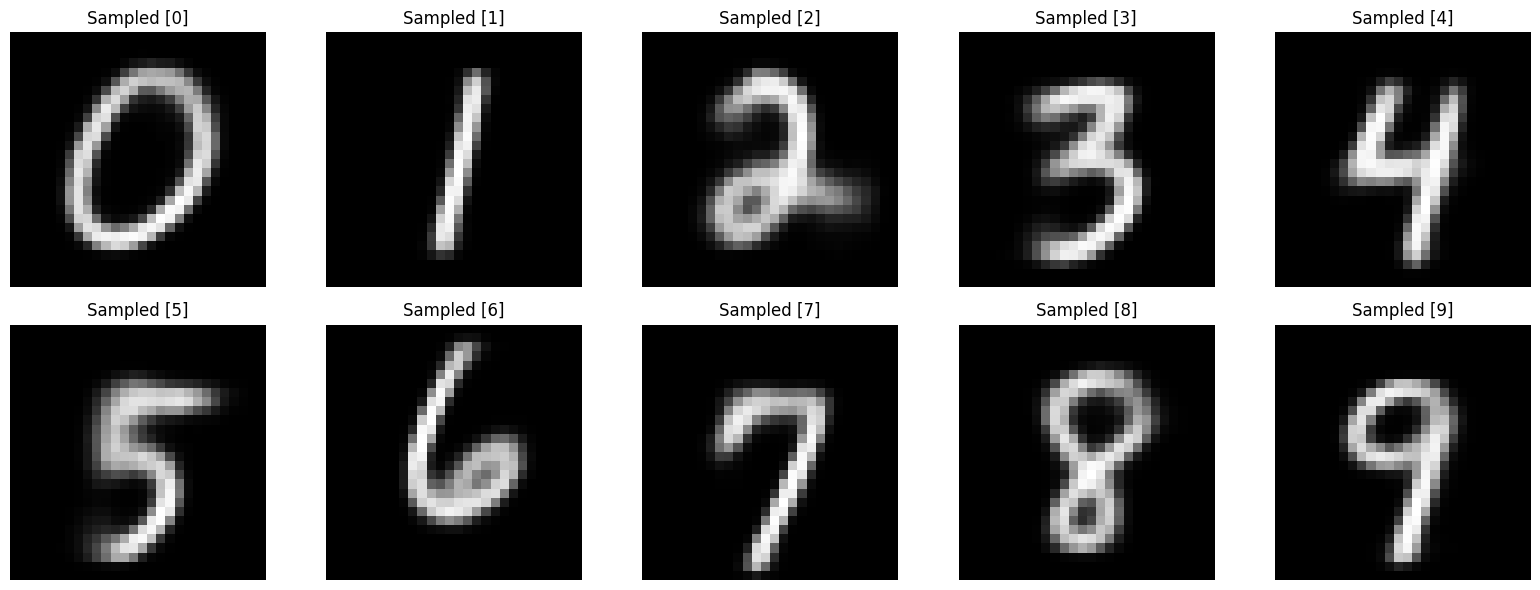

In [ ]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
z = torch.randn(1, cvae_latent_dim)
z = torch.tile(z, dims=(10, 1))
labels = torch.LongTensor(list(range(10)))
cvaeautoencoder.eval()
with torch.no_grad():
    output = cvaeautoencoder.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.set_title(f'Sampled {[5*i+j]}')
        axes.axis('off')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    cvaeautoencoder.eval()
    with torch.no_grad():
        latent = cvaeautoencoder.get_latent_vector(images.to(device), labels.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

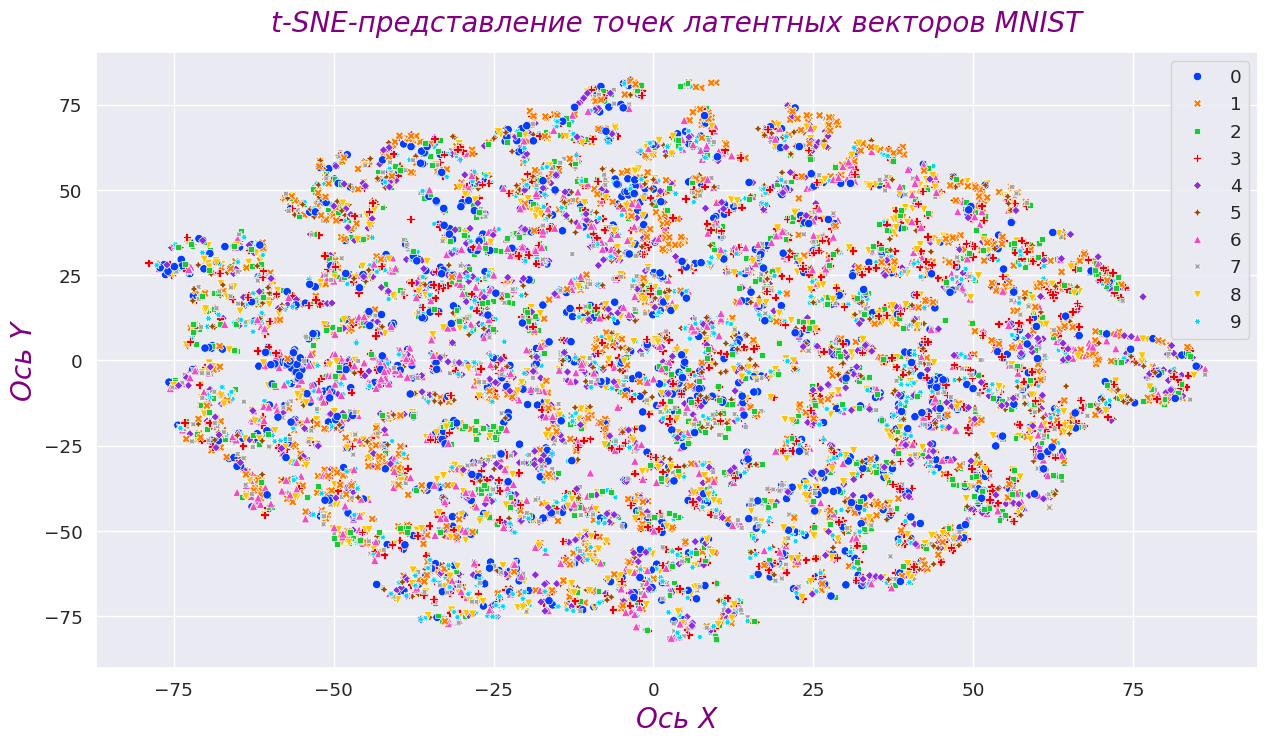

In [ ]:
labels = [i[1] for i in test_dataset]
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('t-SNE-представление точек латентных векторов MNIST', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
ax.set_xlabel('Ось X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
ax.set_ylabel('Ось Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

   1. Представление латентных векторов не имеет четко выраженных границ.
   2. В целом, просматривается закономерность объединения точек в некое подобие кластеров.